In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from astropy.stats import LombScargle
from scipy.stats import kendalltau, weightedtau
from scipy.interpolate import CubicSpline
%matplotlib inline

Convertir longitud de onda al vacío y cálculo del indice S

In [2]:
def convert(lam):
    s = 10**4 / lam
    a = (1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2)) + (0.0001599740894897 / (38.92568793293 - s**2))
    return lam*a

def S_index(wave, flux, vel):
    '''
    Mt Wilson S-Index (Lovis 2011a)
    '''
    
    delta = vel / 3e5 #Doppler shift
    
    alpha = 2.3
    fact  = 8 * 1.09 / 20. #alpha*fact is ~1
    
    #Convert each line wavelength to vacuum
    Hline = convert(3968.470)*(1 + delta)
    Kline = convert(3933.664)*(1 + delta)
    Rline = convert(4001.070)*(1 + delta)
    Vline = convert(3901.070)*(1 + delta)
    
    #Masks for each line
    Hmask = np.abs(wave - Hline) <= 1.09/2.0
    Kmask = np.abs(wave - Kline) <= 1.09/2.0
    Rmask = np.abs(wave - Rline) <= 10.
    Vmask = np.abs(wave - Vline) <= 10.
    
    #Means
    Hmean = np.nanmean(flux[Hmask])
    Kmean = np.nanmean(flux[Kmask])
    Rmean = np.nanmean(flux[Rmask])
    Vmean = np.nanmean(flux[Vmask])
    
    ratio = (Hmean + Kmean) / (Rmean + Vmean)
    return fact*ratio

Las 40 lineas del paper estan en un archivo con su respectiva etiqueta

In [3]:
dlines = pd.read_csv('lines.csv')
nlines = len(dlines)

namel = np.array(dlines['species'])
lines = convert(np.array(dlines['lambda']))

Los espectros son de HD1397 ya que tiene una señal de actividad y habían hartos espectros disponibles ya reducidos. Debo reemplazar en esta celda por Alpha Cen B (o Eps Eri) para reproducir lo del paper. (Esto sería más lento por el tema de las calibraciones, pero intentaré con datos de un mes usando las de un mismo día)

In [4]:
files = glob.glob('/Volumes/Felipe/goceres/HD213885/*sp.fits')

Sidx  = np.zeros(len(files))
cores = np.zeros((nlines, len(files)))

Por el momento si una línea está en dos órdenes, se sobreescribe por la última aparición, dado que todavía no está resuelto ese asunto. Si la resolución implica una concatenación de  todos los órdenes, entonces se eliminaría un for. En el módulo, no se debería iterar sobre todos los archivos, sino guardar estos datos en el header (el índice S lo dejaría en el header, pero los otros indicadores son 40x3).

In [5]:
#fig, ax = plt.subplots(figsize=[18,3])
#Probado con plots que las lineas caen donde corresponde y los minimos

all_cores = []
all_times = []
all_snr   = []
all_rvs   = []
all_rvse  = []
all_names = []

for i,f in enumerate(files):
    data, hdr = fits.getdata(f, header=True)
    all_times.append(hdr['BJD_OUT'])
    all_snr.append(hdr['SNR'])
    
    rv    = hdr['RV']
    delta = rv / 3e5
    slin  = lines*(1 + delta)
    all_rvs.append(rv)
    all_rvse.append(hdr['RV_E'])
    
    #S-index
    bflu  = np.concatenate(data[3])
    zmask = bflu != 0
    
    wave = np.concatenate(data[0])[zmask]
    bflu = bflu[zmask]
    
    Sidx[i] = S_index(wave, bflu, rv)

    dx, dy, dz = np.shape(data) #Esto deberia definirse para cada instrumento (11, n orders, n wavelenghts)
    
    cores = []
    
    for j in xrange(dy):
        cflux = data[5,j]
        zmask = cflux != 0 
        
        cflux = cflux[zmask]
        wave  = data[0,j, zmask]
              
        minw = np.nanmin(wave)
        maxw = np.nanmax(wave)

        lmask = (minw < slin) & (slin < maxw)
        lavai = slin[lmask]
        navai = namel[lmask]
       
        if len(lavai)==0:
            continue
            
        fx = CubicSpline(wave, cflux, extrapolate=False)
        xx = np.linspace(wave.min(), wave.max(), 1e5)
        
        fx1 = fx.derivative(1)
        fx2 = fx.derivative(2)
        
        ext = fx1.roots()
        ext = ext[(ext > minw) & (ext < maxw)]
        sec = fx2(ext)
        all_min = ext[sec > 0]
        
        co = np.zeros(len(lavai))
        for k,l in enumerate(lavai):
            lm = np.argmin(np.abs(all_min - l))
            sl = all_min[lm]
            
            co[k] = fx(sl)
            all_names.append(navai[k])
            
        #Los guardo todos juntos, hay duplicados pero es facil de etiquetar
        #Y al final todavia no se con cual linea de que orden me quedare o si las ponderare
        cores = np.concatenate([cores, co]) 
    
    all_cores.append(cores) #Los voy apilando todos, cada columna corresponde a la "serie de tiempo"

all_cores = np.array(all_cores)
all_times = np.array(all_times)
all_snr   = np.array(all_snr)
all_rvs   = np.array(all_rvs)
all_rvse  = np.array(all_rvse)
all_names = np.array(all_names[:67])

Graficos de S-index vs Flux. Se calcula el tau de correlación.
Faltaría calcular las otras dos cantidades (centro de masa y ancho a medio flujo, que segun el paper les dio menos efectivo que el flujo mismo de la línea, pero quizás acá la cosa mejora)

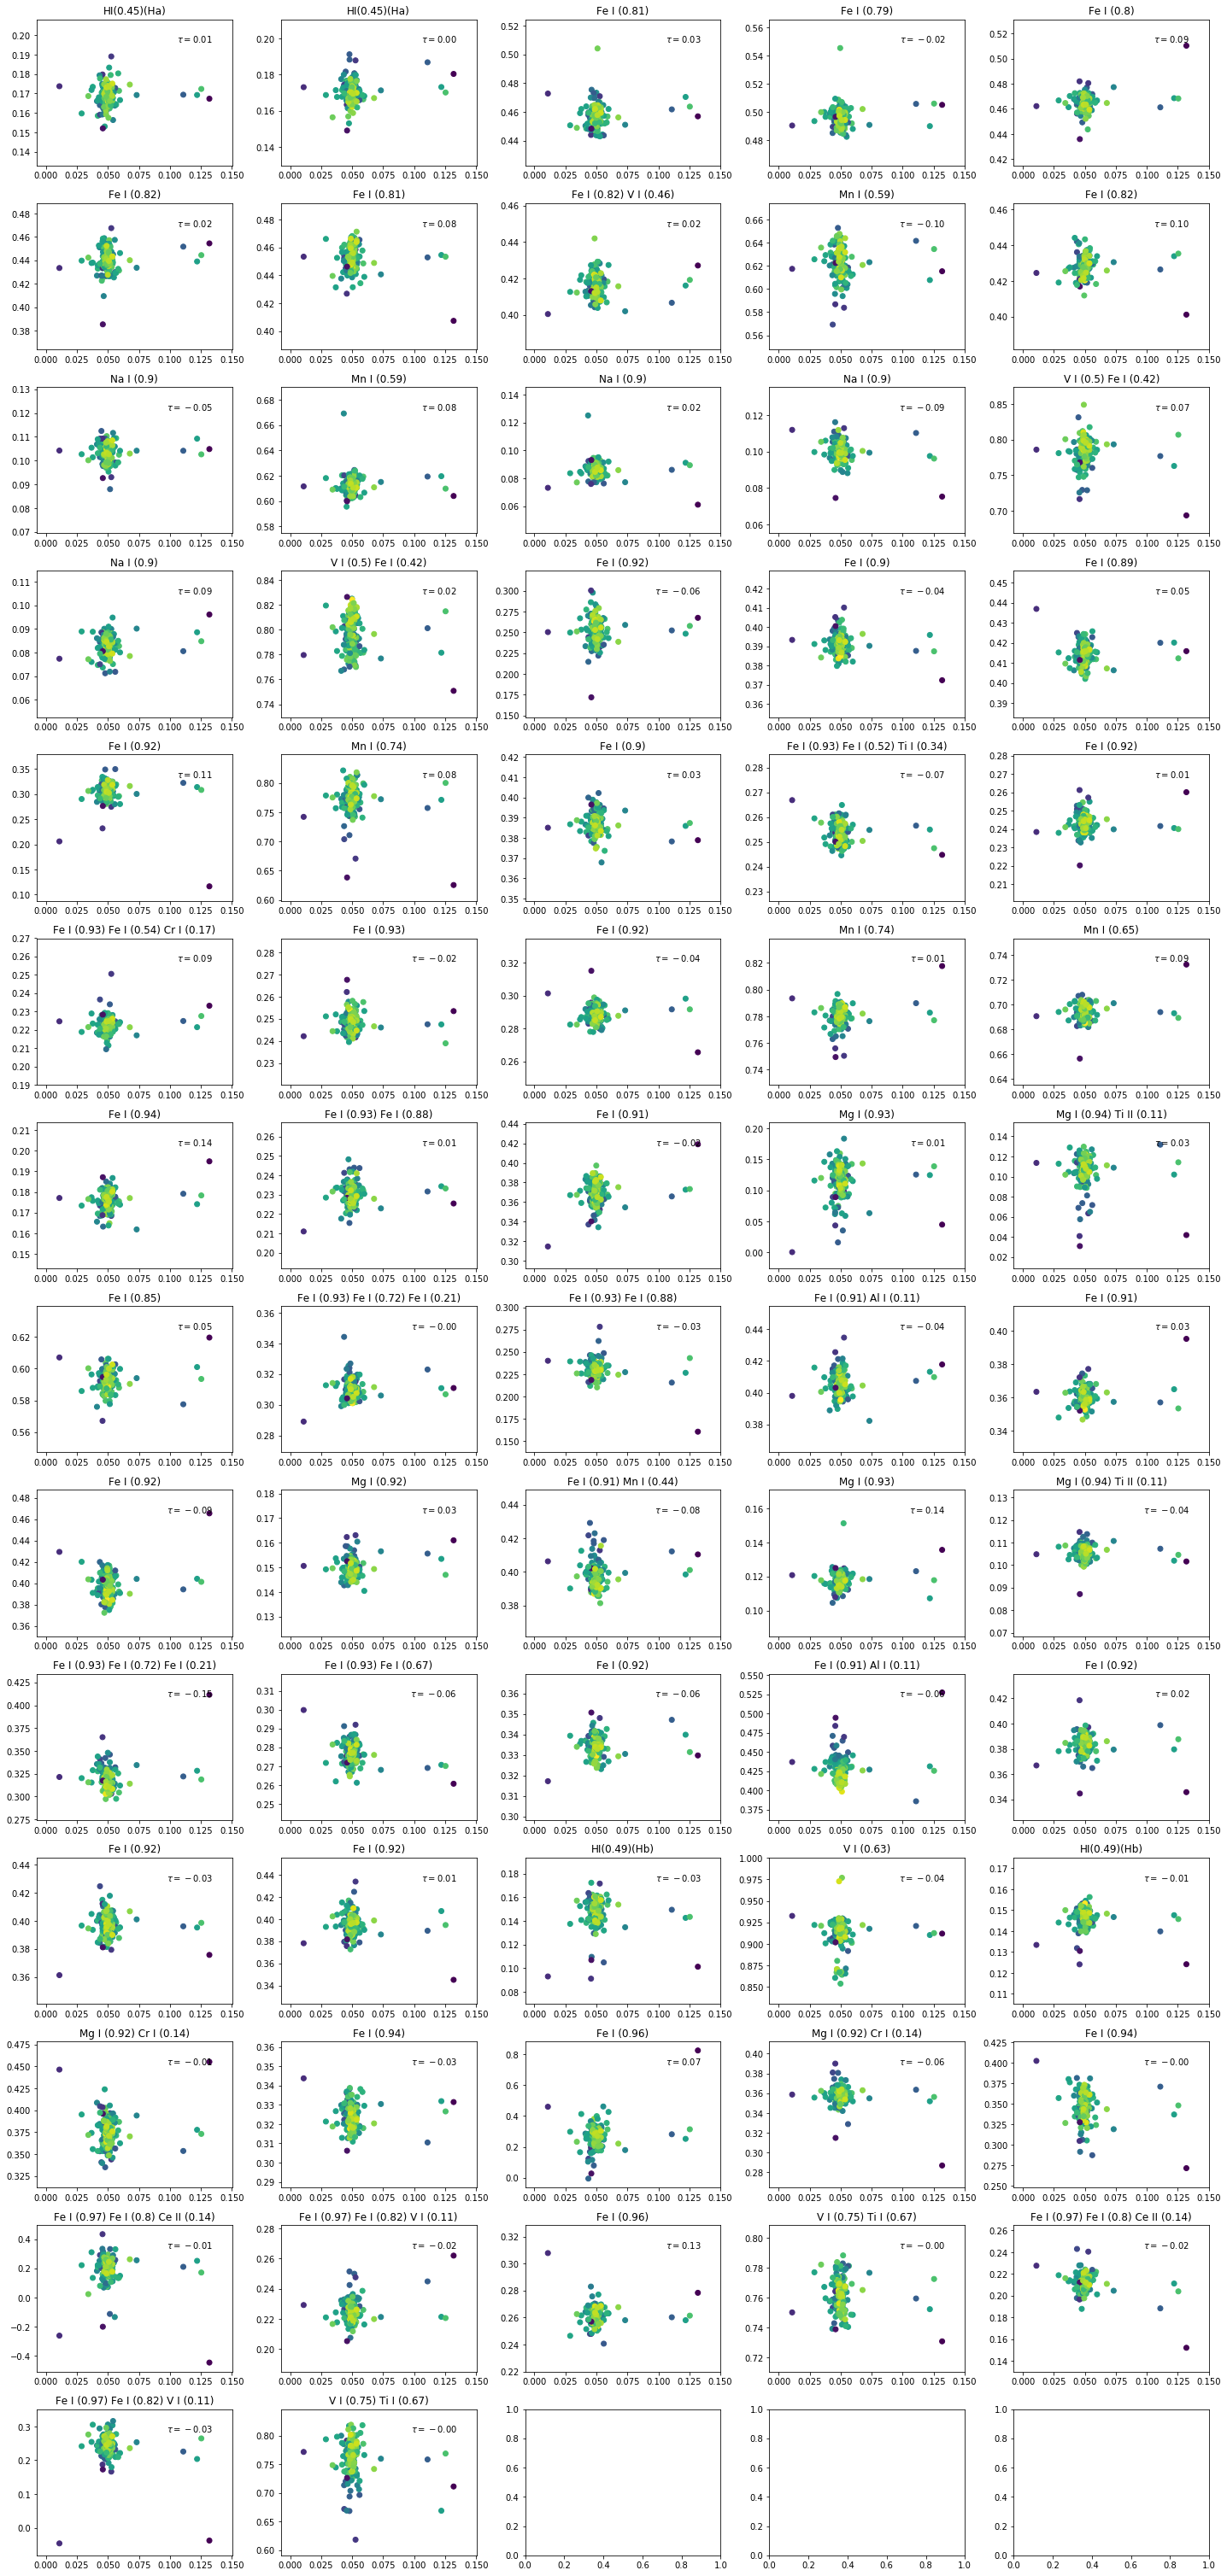

In [6]:
fig, ax = plt.subplots(nrows=14, ncols=5, figsize=[4*5, 3*14])
axs = np.ravel(ax)[:67]

for i,a in enumerate(axs):
    y = all_cores[:,i]
    tau = kendalltau(Sidx, y).correlation
    #tau = weightedtau(Sidx, y, rank=1/all_snr).correlation
    
    a.scatter(Sidx, y, c=all_snr)
    a.text(0.9, 0.9, r'$\tau = %.2f$' % tau, transform=a.transAxes, ha='right', va='top')
    a.set_title(all_names[i])
    
fig.tight_layout()


No se ve tan bien como lo que reportan en el paper, considerando que las ~40 lineas tienen todas tau>=.5. Esto puede ser quizás con otra métrica y no necesariamente el flujo (al menos en unas figuras muestran S-index vs otra cosa). 

Además, falta calibrar el S-index según FEROS. En Lovis 2011a simplemente fitean una transformación lineal (ax+b) para convertir sus S-index desde HARPS hacia los del instrumento del Mt. Wilson.

Ahora corro un GLS sobre cada linea, ya que debería aparecer el peak en ~18 dias en estas. Añado también el del indice S y el de las RV al comienzo. El peak que obtengo está más corrido hacia los 20 días. No he revisado por qué o simplemente sea porque tengo más datos. Los pesé por la SNR pero obtengo prácticamente lo mismo.

En rojo el mejor peak que obtiene el GLS (omitiendo los de período muy corto) y en azul el de 18.237 días reportado en el paper de Rafael.

/Users/felipe/miniconda3/envs/27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


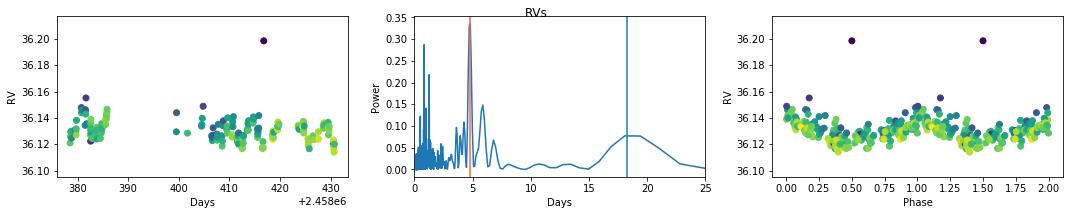

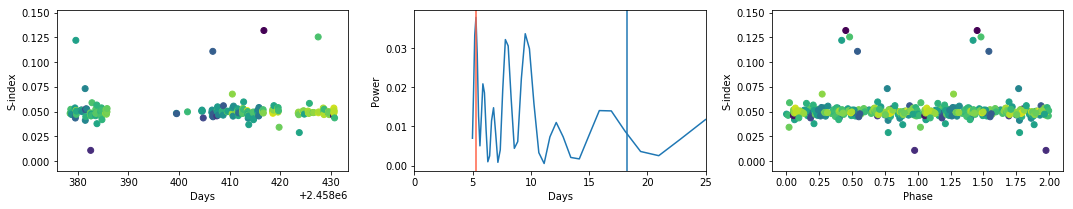

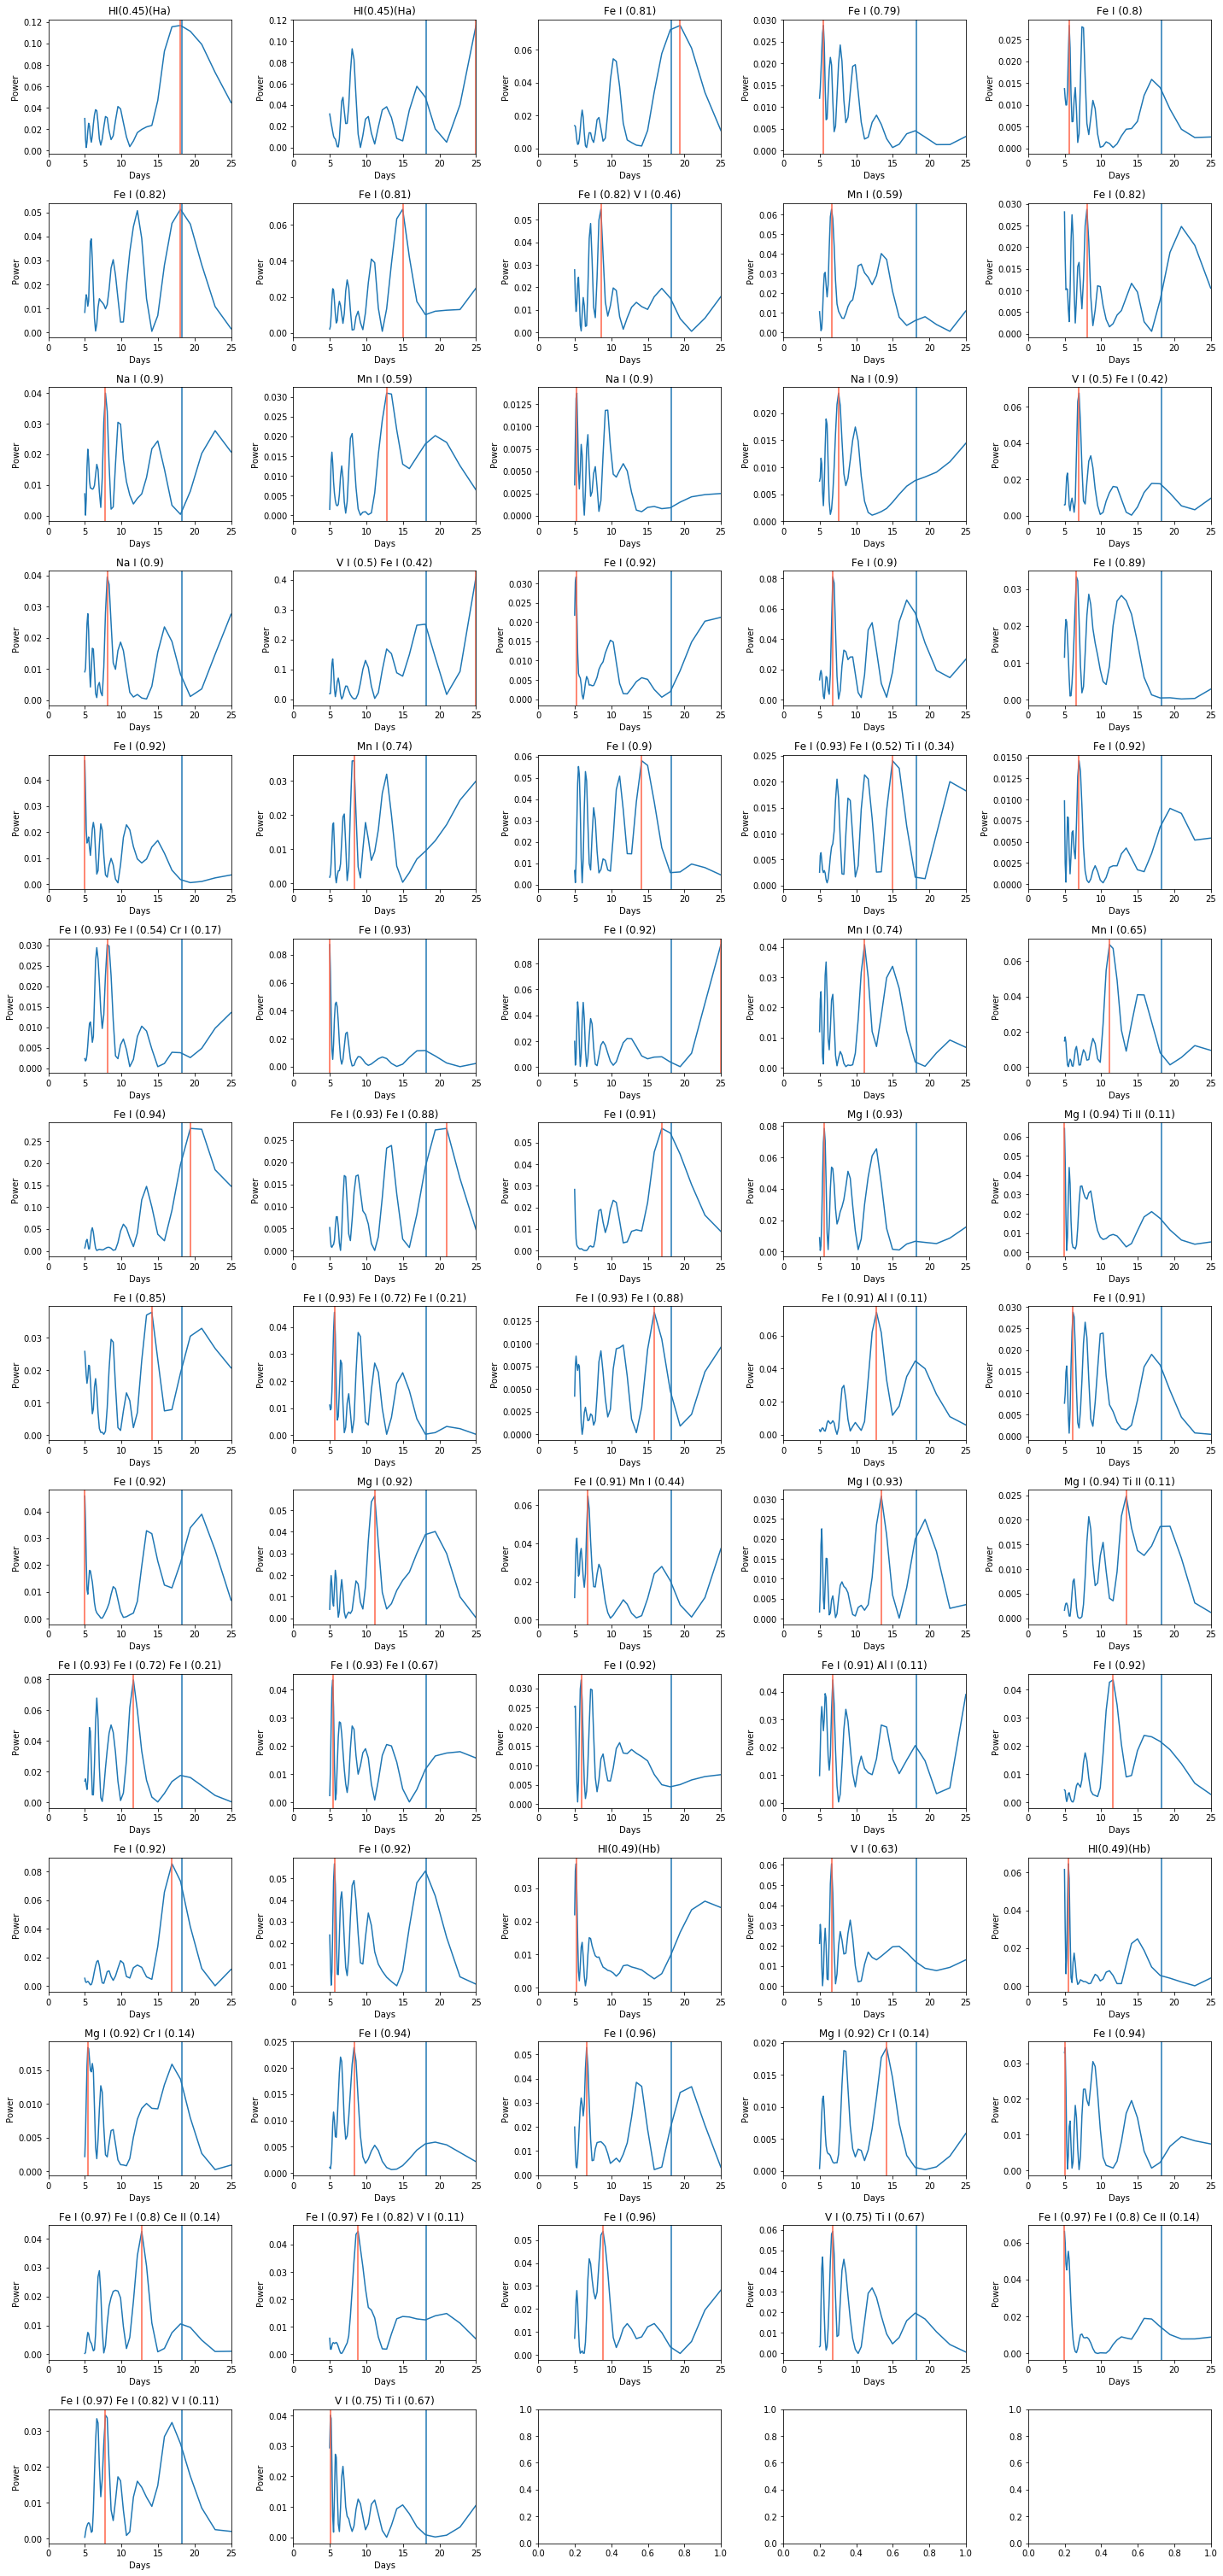

In [7]:
dayg = 1/np.linspace(0,25,2500)
vlin = 18.237

fig, ax = plt.subplots(figsize=[15,3], ncols=3)
freq, pwr = LombScargle(all_times, all_rvs, all_rvse).autopower(minimum_frequency=1/25., maximum_frequency=1/0.1)

ax[0].scatter(all_times, all_rvs, c=all_snr)
ax[0].set_xlabel(r'Days')
ax[0].set_ylabel(r'RV')

ax[1].plot(1/freq, pwr)
ax[1].set_xlim(0,25)
ax[1].axvline(vlin)
ax[1].set_xlabel(r'Days')
ax[1].set_ylabel(r'Power')


bper = 1/freq[np.argmax(pwr)]
ax[1].axvline(bper, color='tomato')

ph = all_times/bper % 1.0
ax[2].scatter(ph, all_rvs, c=all_snr)
ax[2].scatter(1 + ph, all_rvs, c=all_snr)
ax[2].set_xlabel(r'Phase')
ax[2].set_ylabel(r'RV')


fig.suptitle('RVs')
fig.tight_layout()



fig, ax = plt.subplots(figsize=[15,3], ncols=3)
freq, pwr = LombScargle(all_times, Sidx, 1/all_snr).autopower(minimum_frequency=1/25., maximum_frequency=1/5.)

ax[0].scatter(all_times, Sidx, c=all_snr)
ax[0].set_xlabel(r'Days')
ax[0].set_ylabel(r'S-index')
ax[1].plot(1/freq, pwr)
ax[1].set_xlim(0,25)
ax[1].set_xlabel(r'Days')
ax[1].set_ylabel(r'Power')
ax[1].axvline(vlin)

bper = 1/freq[np.argmax(pwr)]
ax[1].axvline(bper, color='tomato')

ph = all_times/bper % 1.0
ax[2].scatter(ph, Sidx, c=all_snr)
ax[2].scatter(1 + ph, Sidx, c=all_snr)
ax[2].set_xlabel(r'Phase')
ax[2].set_ylabel(r'S-index')

fig.tight_layout()

fig, ax = plt.subplots(nrows=14, ncols=5, figsize=[4*5, 3*14])
axs = np.ravel(ax)[:67]

for i,a in enumerate(axs):
    y = all_cores[:,i]
    freq, pwr = LombScargle(all_times, y, 1/all_snr).autopower(minimum_frequency=1/25., maximum_frequency=1/5.)
    #tau = kendalltau(Sidx, y).correlation
    
    a.plot(1/freq, pwr)
    a.set_xlim(0,25)
    a.axvline(vlin)
    
    bper = 1/freq[np.argmax(pwr)]
    a.axvline(bper, color='tomato')
    a.set_title(all_names[i])
    a.set_xlabel(r'Days')
    a.set_ylabel(r'Power')


fig.tight_layout()
    #a.scatter(all_times, y, c=all_snr)
    #a.text(0.9, 0.9, r'$\tau = %.2f$' % tau, transform=a.transAxes, ha='right', va='top')
